In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb

import ads

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

import time

import matplotlib.pyplot as plt

import pickle

%matplotlib inline

In [5]:
# check the ADS version
print(ads.__version__)

2.5.8


In [6]:
data = pd.read_csv('cs-training-nonull.csv')

# remove unneeded
data = data.drop('id', axis = 1)

In [7]:
# global constants
N_ESTIMATORS = 1000
# numero di features compreso le due colonne indicatore aggiunte
N_FEATURES = 12

# nome della colonna con le label
TARGET = 'SeriousDlqin2yrs'

# colonne con missing values
COL1_MISSING = 'MonthlyIncome'
COL2_MISSING = 'NumberOfDependents'

# nomi delle due colonne indicator (valgono 1 laddove il dato è inputato)
IND1 = 'isna_mi'
IND2 = 'isna_nod'

ind_col = [IND1, IND2]

# prese da stats sul train test, usate per inputare i missing values su COL1 e CL2
MONTHLY_INC_MEDIAN = 5400.0
N_OF_DEP_MODE = 0

In [8]:
# split in train, validation set
def split_train_test(df, ratio):
    # shuffle before split
    df = df.sample(frac = 1)
    N_REC = df.shape[0]
    N_TRAIN = int(N_REC * ratio)
    N_VALID = N_REC - N_TRAIN
    train_df = df[:N_TRAIN]
    valid_df = df[N_TRAIN:]
    
    return train_df, valid_df

In [9]:
train_df, valid_df = split_train_test(data, 0.8)

In [10]:
# metto da parte le due colonne indicatori
ind_train = train_df[ind_col].values
ind_valid = valid_df[ind_col].values

In [11]:
train_df = train_df.drop(ind_col, axis = 1)
valid_df = valid_df.drop(ind_col, axis = 1)

# estrae X: matrice features ed y, labels
y_train = train_df[TARGET].values
xtrain_df = train_df.drop(TARGET, axis = 1)
x_train = xtrain_df.values

y_valid = valid_df[TARGET].values
xvalid_df = valid_df.drop(TARGET, axis = 1)
x_valid = xvalid_df.values

In [12]:
# prepara lo scaling
scaler = StandardScaler()

# calcola i parametri di scaling solo sul train set
scaler.fit(x_train)

StandardScaler()

In [13]:
# scalo tutto tranne che le due colonne indicatore
x_train_scaled = scaler.transform(x_train)
x_valid_scaled = scaler.transform(x_valid)

In [14]:
# riaggiungo gli indicatori (che non vengono scalati)
x_train_scaled = np.c_[x_train_scaled, ind_train]
x_valid_scaled = np.c_[x_valid_scaled, ind_valid]

In [15]:
# check
assert x_train_scaled.shape[1] == N_FEATURES
assert x_valid_scaled.shape[1] == N_FEATURES

### Train the XGBoost Classifier

In [19]:
%%time

param = {'objective':'binary:logistic', 'n_estimators':N_ESTIMATORS,
             'learning_rate':0.007, 'max_depth': 5,
             'random_state': 0, 'min_child_weight': 10.0,
             'max_delta_step': 1.8, 'colsample_bytree': 0.4,
             'subsample': 0.8, 'eta': 0.025,
             'gamma': 0.65}

clf = xgb.XGBClassifier(use_label_encoder=False, **param)

# addestro e valuto su train e su validation set
clf.fit(x_train_scaled, y_train,
        eval_set=[(x_train_scaled, y_train), (x_valid_scaled, y_valid)],
        eval_metric='auc', verbose=100)

print()

evals_result = clf.evals_result()

[0]	validation_0-auc:0.70318	validation_1-auc:0.69922
[100]	validation_0-auc:0.86609	validation_1-auc:0.86370
[200]	validation_0-auc:0.86678	validation_1-auc:0.86471
[300]	validation_0-auc:0.86765	validation_1-auc:0.86539
[400]	validation_0-auc:0.86855	validation_1-auc:0.86579
[500]	validation_0-auc:0.86968	validation_1-auc:0.86633
[600]	validation_0-auc:0.87068	validation_1-auc:0.86668
[700]	validation_0-auc:0.87167	validation_1-auc:0.86701
[800]	validation_0-auc:0.87267	validation_1-auc:0.86723
[900]	validation_0-auc:0.87349	validation_1-auc:0.86751
[999]	validation_0-auc:0.87434	validation_1-auc:0.86760

CPU times: user 50min 38s, sys: 9.89 s, total: 50min 48s
Wall time: 3min 51s


In [22]:
def plot_auc(train_hist, val_hist):
    plt.figure(figsize=(9,6))
    
    plt.plot(train_hist, label='Training AUC')
    plt.plot(val_hist, label='Validation AUC')
    plt.title('AUC')
    plt.legend(loc='lower right')
    plt.ylabel('auc')
    plt.xlabel('n_estimator')
    plt.grid(True)
    plt.show();

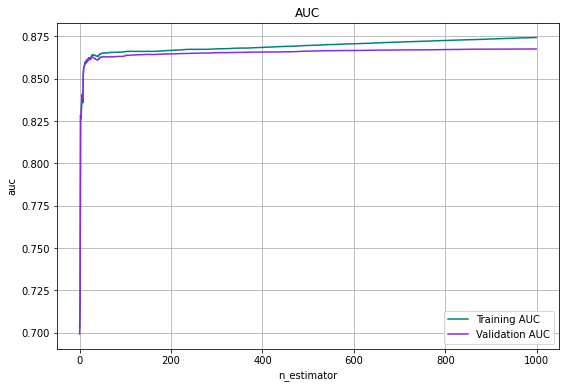

In [23]:
train_hist = evals_result['validation_0']['auc']
val_hist = evals_result['validation_1']['auc']

plot_auc(train_hist, val_hist)

In [24]:
# compute accuracy on validation set
y_pred = clf.predict(x_valid_scaled)

predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_valid, predictions)

print("Accuracy on validation set: %.2f%%" % (accuracy * 100.0))

Accuracy on validation set: 93.77%


In [25]:
# compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_valid, predictions).ravel()

(tn, fp, fn, tp)

(27794, 233, 1637, 336)

### Prediction on the TEST set (for submission to Kaggle)

In [26]:
# predictions on test set
orig_test = pd.read_csv('cs-test.csv')

# inpute missing values, add the two indicator columns
orig_test['isna_mi'] = 0
orig_test.loc[orig_test[COL1_MISSING].isna(), 'isna_mi'] = 1
orig_test.loc[orig_test[COL1_MISSING].isna(), COL1_MISSING] = MONTHLY_INC_MEDIAN

orig_test['isna_nod'] = 0
orig_test.loc[orig_test[COL2_MISSING].isna(), 'isna_nod'] = 1
orig_test.loc[orig_test[COL2_MISSING].isna(), COL2_MISSING] = N_OF_DEP_MODE

In [27]:
ind_test = orig_test[ind_col].values

In [28]:
orig_test = orig_test.drop(ind_col, axis = 1)

In [29]:
ID_COL_NAME = 'Unnamed: 0'
xorig_test = orig_test.drop(ID_COL_NAME, axis = 1)
xorig_test = xorig_test.drop(TARGET, axis = 1)

x_test = xorig_test.values

In [30]:
# aggiungi qui lo scaling !!!
x_test_scaled = scaler.transform(x_test)
# riaggiunge le colonne indicatore
x_test_scaled = np.c_[x_test_scaled, ind_test]

assert x_test_scaled.shape[1] == N_FEATURES

In [31]:
# do predictions on test set (no shuffle !)
y_pred = clf.predict_proba(x_test_scaled)

# y_pred contiene le probabilità
y_pred = y_pred[:, 1]

In [32]:
# prepara il csv per la submission
result_dict = {"Id": orig_test[ID_COL_NAME].values,
              'Probability': y_pred}

FILE_SUB = 'submission25.csv'

# build a dataframe and save to csv
result_df = pd.DataFrame(result_dict)

result_df.to_csv(FILE_SUB, index=False, float_format='%.5f')

In [33]:
### Save Modela and scaler

In [34]:
# save model: uso un formato semplice: pkl
pickle.dump(clf, open("credit-scoring.pkl", "wb"))

In [35]:
# salvo anche lo scaler
pickle.dump(scaler, open("scaler.pkl", "wb"))

### Online predictions

In [36]:
# reload the model
loaded_model = pickle.load(open("credit-scoring.pkl", "rb"))

In [37]:
# reload the scaler
loaded_scaler = pickle.load(open("scaler.pkl", "rb"))

In [39]:
# prepare for online predictions
# input are given as a numpy array, with no missing fields, but we need to add the two indicator columns
x_input = np.array([[1,2,3,4,5,6,7,8,9,10],
                   [1,2,3,4,5,6,7,8,9,10],
                   [1,2,3,4,5,6,7,8,9,10]])

In [40]:
# controlli
assert x_input.shape[1] == 10
# check there are no null
assert np.sum(np.isnan(x_input)) == 0

In [41]:
# normalize
x_input_scaled = loaded_scaler.transform(x_input)

# add two columns with 0
x_add = np.zeros((x_input.shape[0], 2))
x_input_scaled = np.c_[x_input_scaled, x_add]

In [42]:
y_pred = loaded_model.predict(x_input_scaled)

In [43]:
y_pred

array([1, 1, 1])

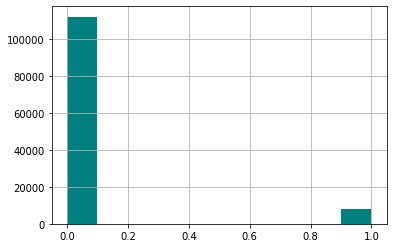

In [44]:
train_df[TARGET].hist();